# Deep Belief Modeling
Project for SI course

## Imports

In [1]:
import pandas as pd

## Loading data

In [2]:
df_train = pd.read_csv("resources/data.csv", sep="\t")
# maybe add test data in future

## Input data visualisation

<AxesSubplot:>

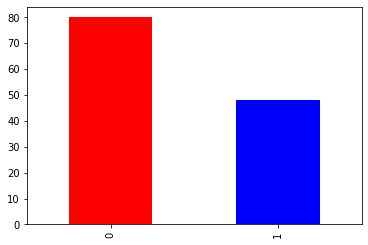

In [3]:
x = df_train["label"].value_counts()
x.plot(kind="bar", color=["r", "b"])

## Text pre-processing for classification

In [4]:
from preprocessing.article import word_preprocess

In [5]:
print(df_train["data"].head(10))
print(df_train["data"].head(10).apply(word_preprocess))

0    It's been quite a week. I've been in the media...
1    This week has been eye-opening. Even for me --...
2    Yes, it's true. I beat COVID-19 in 48 hours wi...
3    The COVID-19 vaccines appear to be causing a g...
4    Back in the 1980s, I was a Columbia University...
5    So you got the vaccine because they told you t...
6    I Am A Living Proof That COVID-19 Is Fake This...
7    I have a PhD in virology and immunology. I’m a...
8    How do you convince the world’s population to ...
9    Take 15 minutes and listen to this interview w...
Name: data, dtype: object
0    [quite, week, medium, business, decade, never,...
1    [week, eye, opening, even, guy, warned, year, ...
2    [yes, true, beat, covid, hour, ivermectin, get...
3    [covid, vaccine, appear, causing, global, heal...
4    [back, columbia, university, student, learning...
5    [got, vaccine, told, get, forced, get, joe, bi...
6    [living, proof, covid, fake, unfiltered, take,...
7    [phd, virology, immunology, clinic

## Feature selection

### TF-IDF Vectorizer

In [6]:
# https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a
import pickle

with open("model_storage/vectorizer.pkl","rb") as file:
    tfidf_vectorizer = pickle.load(file)

with open("model_storage/bow.pkl","rb") as file:
    tfidf_wm = pickle.load(file)

with open("model_storage/classifier.pkl","rb") as file:
    clf = pickle.load(file)

tfidf_tokens = tfidf_vectorizer.get_feature_names_out()

print(tfidf_tokens)

df_tfidf_vect = pd.DataFrame(data=tfidf_wm.toarray(), columns=tfidf_tokens)

print("Tf-idf vectorizer")
print(df_tfidf_vect)

['aabduzrw' 'aaby' 'aaho' ... 'zoster' 'zuckerberg' 'zurich']
Tf-idf vectorizer
     aabduzrw  aaby  aaho  aamcnews     aaron  aarp    abbott  abby  abc  \
0         0.0   0.0   0.0       0.0  0.000000   0.0  0.000000   0.0  0.0   
1         0.0   0.0   0.0       0.0  0.000000   0.0  0.000000   0.0  0.0   
2         0.0   0.0   0.0       0.0  0.032700   0.0  0.000000   0.0  0.0   
3         0.0   0.0   0.0       0.0  0.000000   0.0  0.000000   0.0  0.0   
4         0.0   0.0   0.0       0.0  0.000000   0.0  0.000000   0.0  0.0   
..        ...   ...   ...       ...       ...   ...       ...   ...  ...   
123       0.0   0.0   0.0       0.0  0.054671   0.0  0.000000   0.0  0.0   
124       0.0   0.0   0.0       0.0  0.000000   0.0  0.000000   0.0  0.0   
125       0.0   0.0   0.0       0.0  0.000000   0.0  0.000000   0.0  0.0   
126       0.0   0.0   0.0       0.0  0.000000   0.0  0.037119   0.0  0.0   
127       0.0   0.0   0.0       0.0  0.000000   0.0  0.000000   0.0  0.0   

     ab

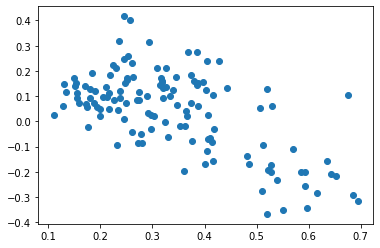

In [7]:
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD

clftr = TruncatedSVD(2)
Xpca = clftr.fit_transform(tfidf_wm)
plt.scatter([x[0] for x in Xpca],[x[1] for x in Xpca])
plt.show()

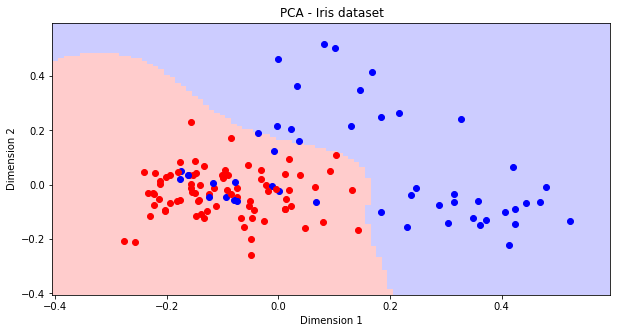

In [8]:
from random import randint
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
h = .01
x_min, x_max = -0.4,0.6
y_min, y_max = -0.4,0.6
# loading dataset
data = load_iris()
X, y = tfidf_wm.toarray(), df_train["label"]
# selecting first 2 components of PCA
X_selected = PCA(2).fit_transform(X)
# training classifier and evaluating on the whole plane
clfsvc = SVC()
clfsvc.fit(X_selected,y)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clfsvc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plotting
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.figure(figsize=(10,5))
plt.pcolormesh(xx, yy, Z, alpha=.6,cmap=cmap_light)
plt.title('PCA - Iris dataset')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
for xy,c in zip(X_selected,df_train["label"]):
    plt.scatter(xy[0],xy[1],c= 'red' if c == 0 else 'blue')
plt.show()


In [9]:
from model.features import f_importances_graph

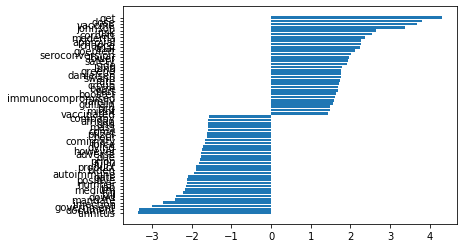

In [53]:
slowa_anty, slowa_pro = f_importances_graph(clf.coef_,tfidf_tokens, limit=30)

In [26]:
with open("model_storage/words_pa.pkl","rb") as file:
    words_pa = pickle.load(file)

In [54]:
from collections import defaultdict

slownik_anty = {s:defaultdict(int) for _,s in slowa_anty}
slownik_pro = {s:defaultdict(int) for _,s in slowa_pro}
r = 3

for a in words_pa:
    for i,w in enumerate(a):
        for slownik in (slownik_pro,slownik_anty):
            if w in slownik.keys():
                for n in range(max(i-r,0),min(i+r,len(a))):
                    if a[n] not in slownik.keys():
                        slownik[w][a[n]]+=1

In [55]:
data_pro={}
for i,(k,d) in enumerate(slownik_pro.items()):
    for w,v in d.items():
        if v > 1:
            if w not in data_pro.keys():
                data_pro[w] = [0 for _ in slownik_pro.keys()]
            data_pro[w][i] = v


pro = pd.DataFrame(data_pro,index=slownik_pro.keys())
pro

,everyone,question,within,day,getting,considered,unvaccinated,die,covid,whether,...,home,traveling,good,seriously,simple,describes,chloroform,sued,sicker,monoclonal
vaccinated,6,2,3,3,22,4,14,4,35,4,...,0,0,0,0,0,0,0,0,0,0
might,0,0,0,0,4,0,0,0,9,0,...,0,0,0,0,0,0,0,0,0,0
bcg,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
guillain,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
family,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
immunocompromised,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
booster,0,0,0,0,4,0,2,0,22,3,...,0,0,0,0,0,0,0,0,0,0
part,0,0,0,4,0,0,0,0,6,0,...,0,0,0,0,0,0,0,0,0,0
barré,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
croup,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
data_anty={}
for i,(k,d) in enumerate(slownik_anty.items()):
    for w,v in d.items():
        if v > 1:
            if w not in data_anty.keys():
                data_anty[w] = [0 for _ in slownik_anty.keys()]
            data_anty[w][i] = v


anty = pd.DataFrame(data_anty,index=slownik_anty.keys())
anty

,said,developed,second,people,developing,covid,vaccine,list,side,effect,...,arm,hundred,manufactured,cayman,period,ingredient,describes,simple,maybe,okay
tinnitus,2,4,2,5,2,8,8,2,3,3,...,0,0,0,0,0,0,0,0,0,0
document,0,0,0,0,0,9,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
government,5,0,0,8,0,4,26,0,0,0,...,0,0,0,0,0,0,0,0,0,0
injection,2,0,3,5,0,20,11,0,3,4,...,0,0,0,0,0,0,0,0,0,0
mandate,0,0,0,3,0,6,21,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dowd,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bill,0,0,0,2,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
medium,0,0,0,3,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
jab,2,0,3,7,0,18,4,0,0,3,...,0,0,0,0,0,0,0,0,0,0
number,0,0,0,25,0,18,45,0,3,4,...,0,0,0,0,0,0,0,0,0,0
